In [1]:
import numpy as np
from SynthTempNetwork import Individual, SynthTempNetwork
from TemporalNetwork import ContTempNetwork, StaticTempNetwork
from FlowStability import SparseClustering, FlowIntegralClustering, run_multi_louvain, avg_norm_var_information
import parallel_clustering
import pickle

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
import matplotx

from scipy.sparse import (lil_matrix, dok_matrix, diags, eye, isspmatrix_csr, isspmatrix,
                          csr_matrix, coo_matrix, csc_matrix)
from scipy.sparse.linalg import eigsh

from SparseStochMat import sparse_autocov_mat
import auxiliary_functions

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.image as mpimg

Could not load sparse_dot_mkl. Will use scipy.sparse for matrix products.


In [2]:
net_heat = ContTempNetwork.load('fig3_growing_network300')

In [3]:
# Example matrices for demonstration
matrix1 = net_heat.compute_static_adjacency_matrix(start_time=0, end_time=100).toarray()
matrix2 = net_heat.compute_static_adjacency_matrix(start_time=100, end_time=200).toarray()
matrix3 = net_heat.compute_static_adjacency_matrix(start_time=200, end_time=300).toarray()

# Define the time intervals for the x-axis
time_intervals = [(0, 100), (100, 200), (200, 300)]

In [7]:
lamdas_growing = np.logspace(-4.5,-0.5,200)

multi_res_heat = {}
for lamda in lamdas_growing:
    with open(f'//scratch/tmp/180/skoove/growing_experiment300_temporal_heat/clustersplot/cluster{lamda:.11f}', 'rb') as f:
        cluster = pickle.load(f)

    multi_res_heat[lamda] = cluster
avg_nclusters_forw_heat = [np.mean([len(c) for c in \
                   multi_res_heat[lamda] if len(c)>1]) for lamda in lamdas_growing]

NVI_forw_heat = [avg_norm_var_information(multi_res_heat[lamda]) for lamda in lamdas_growing]

multi_res_rw = {}
for lamda in lamdas_growing:
    with open(f'//scratch/tmp/180/skoove/growing_experiment300_temporal_rw/clustersplot/cluster{lamda:.11f}', 'rb') as f:
        cluster = pickle.load(f)
        
    multi_res_rw[lamda] = cluster
avg_nclusters_forw_rw = [np.mean([len(c) for c in \
                   multi_res_rw[lamda] if len(c)>1]) for lamda in lamdas_growing]

NVI_forw_rw = [avg_norm_var_information(multi_res_rw[lamda]) for lamda in lamdas_growing]

In [8]:
selected_lamdas = np.logspace(-3,1,10)
sample_times = list(np.arange(0, len(net_heat.times), 10))

Conditional_S_selected = []
for i, lamda in enumerate(selected_lamdas):
    with open(f'//scratch/tmp/180/skoove/growing_experiment300_temporal_rw/conditional_S_selected/S_rate{lamda:.11f}', 'rb') as f:
        S_rate = pickle.load(f)
        Conditional_S_selected.append(S_rate['S_rate'][f'{lamda:.11f}']) #(S[list(S.keys))[0]][0])

/tmp/ipykernel_3964147/2295164856.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


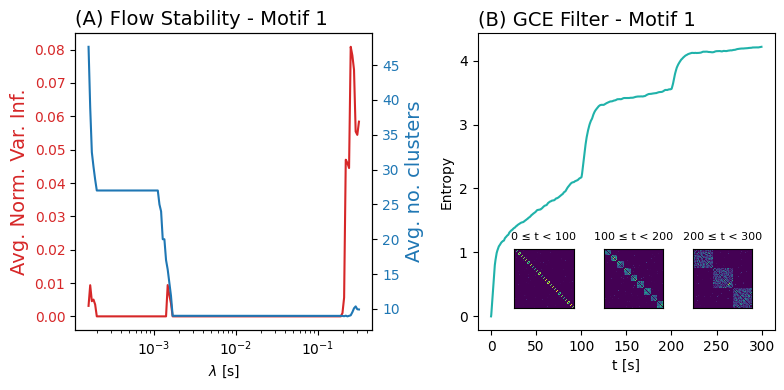

In [ ]:
# Start creating the figure
fig = plt.figure(figsize=(16, 4))  # Wider figure for all plots in one row
gs = fig.add_gridspec(1, 4)  # Grid: 1 row, 4 columns

# Column 1: Plot A
ax_a = fig.add_subplot(gs[0, 1])
color = 'lightseagreen'
index = 5
smoothing_window = 50
S = Conditional_S_selected[index]

ax_a.plot(net_heat.times[sample_times], S, color=color, alpha=1)
ax_a.set_xlabel("t [s]")
ax_a.set_ylabel("Entropy")
ax_a.set_title("(B) GCE Filter - Motif 1", loc='left', fontsize=14)

# Add inset plots for the matrices inside Plot A
matrices = [matrix1, matrix2, matrix3]
positions = [0.10, 0.40, 0.70]  # Horizontal positions for the insets
for i, (matrix, pos) in enumerate(zip(matrices, positions)):
    inset_ax = inset_axes(ax_a, width="20%", height="20%", loc="lower left", 
                          bbox_to_anchor=(pos, 0.05, 1, 1), bbox_transform=ax_a.transAxes)
    inset_ax.matshow(matrix, aspect='equal')  # Keep aspect ratio equal to preserve square shape
    inset_ax.set_xticks([])
    inset_ax.set_yticks([])
    inset_ax.set_title(f"{time_intervals[i][0]} ≤ t < {time_intervals[i][1]}", fontsize=8)

# Column 2: Plot B
ax_b = fig.add_subplot(gs[0, 0])
####### First Plot
color = 'tab:red'
ax_b.plot(lamdas_growing[35:], NVI_forw_rw[35:], color=color, label='static norm NVI')

ax_b.set_xscale('log')
ax_b.set_xlabel(r'$\lambda$ [s]')
ax_b.set_ylabel('Avg. Norm. Var. Inf.', color=color, fontsize = 14)
ax_b.tick_params(axis='y', labelcolor=color)
ax_b.set_title('(A) Flow Stability - Motif 1', loc='left', fontsize=14)

ax1 = ax_b.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax1.plot(lamdas_growing[35:], avg_nclusters_forw_rw[35:], color=color, label='edge-centric')

ax1.set_xlabel(r'$\lambda$ [s]', fontsize = 14)
ax1.set_ylabel('Avg. no. clusters', color=color, fontsize = 14)  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor=color)


# Adjust layout and display
plt.tight_layout()
#plt.savefig('/home/b/skoove/Desktop/growing300/GCE_filter_fig.png', format='png', dpi=300, bbox_inches='tight')
plt.show()